In [1]:
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import random
from pathlib import Path
from PIL import Image
from IPython.display import clear_output
#from scikitplot.metrics import plot_confusion_matrix, plot_roc
import tensorflow as tf

# From TensorFlow
from tensorflow.data.experimental import AUTOTUNE
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, RandomRotation
from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50V2, EfficientNetB0, EfficientNetB5, EfficientNetB7, DenseNet121, ResNet152V2
#from classification_models.tfkeras import Classifiers
#ResNet18, preprocess_input = Classifiers.get('resnet18')
#ResNet34, preprocess_input = Classifiers.get('resnet34')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras
from keras.models import load_model, Model
from keras.initializers import glorot_uniform
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC, PrecisionAtRecall, SpecificityAtSensitivity, PrecisionAtRecall
from tensorflow.keras.losses import BinaryCrossentropy

# From scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score
from sklearn.utils import resample

#set_global_policy('mixed_float16')
set_global_policy('float32')

SEED = 42

# Python's built-in random module
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# TensorFlow
tf.random.set_seed(SEED)

# Force deterministic behavior
#os.environ['TF_DETERMINISTIC_OPS'] = '1'
#os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
#os.environ['OMP_NUM_THREADS'] = '1'
#os.environ['TF_NUM_INTRAOP_THREADS'] = '1'

# GPU Availability

In [2]:
# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {gpus}")
else:
    print("No GPU detected.")

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Constants and Hyperparameters

In [3]:
BATCH_SIZE = 64
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IM_SIZE = 128
EPOCHS = 50
LEARN_RATE = 0.0001
REG_RATE = 0.001
NEURONS = 64
DROPOUT_RATE = 0.5
TRAIN_TEST_SPLIT = 0.15
ACTIVATION = 'relu'
MODEL = 'rn152v2'
VERSION = '2'

# Read the dataset
ROOT_DATASET_DIR = "../"
DATASET = os.path.join(ROOT_DATASET_DIR,"images")

# Evaluation Functions

In [4]:
# Ploting model loss during training, created by Daniel: https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5
class plot_learning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

# Image Preprocessing Functions

In [5]:
# Function for custom normalization
def custom_normalization(image):
    image = image / 255.0
    mean = tf.constant(MEAN, dtype=image.dtype)
    std = tf.constant(STD, dtype=image.dtype)
    image = (image - mean) / std  # Normalize each channel
    return image

rotate_image = RandomRotation(factor=0.2)

def random_zoom(image, min_val=0.8, max_val=1.2):
    # Random zoom
    zoom_scale = tf.random.uniform([], minval=min_val, maxval=max_val)
    original_size = tf.shape(image)[0:2]
    new_size = tf.cast(zoom_scale * tf.cast(original_size, tf.float32), tf.int32)
    image = tf.image.resize_with_crop_or_pad(image, new_size[0], new_size[1])
    image = tf.image.resize(image, original_size)
    return image
    
# Function to add Gaussian noise
def gaussian_noise(image, mean=0.0, stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    image = tf.add(image, noise)
    return image

def gaussian_blur(image, kernel_size=5, sigma=1.0): 
    kernel = gaussian_kernel(kernel_size, 0.0, sigma)
    image = tf.expand_dims(image, axis=0)
    image = tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], padding='SAME')
    return tf.squeeze(image, axis=0)
    
# Image augmentation
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Horizontal flip
    image = tf.image.random_flip_up_down(image) # Vertical flip
    #angle = tf.random.uniform([], minval=-20, maxval=20)
    image = rotate_image(image)
    image = tf.image.random_brightness(image, max_delta=0.5)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)  # Random contrast
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)  # Random saturation
    #image = random_zoom(image, min_val=0.8, max_val=1.2)
    #image = tf.image.random_hue(image, max_delta=0.1)
    #image = gaussian_noise(image, mean=0.0, stddev=0.1) 
    #image = gaussian_blur(image, kernel_size=5, sigma=1.0)
    return image, label

# Parse and process images
def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IM_SIZE, IM_SIZE]) #, method=tf.image.ResizeMethod.LANCZOS3)
    image = custom_normalization(image)
    return image, label

# Generate dataset from file paths
def generate_dataset(file_paths, labels, batch_size, is_training):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=1000)  # Use a reasonable buffer size
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# List image paths and labels
def get_image_paths_and_labels(directory):
    data_dir = Path(directory)    
    all_image_paths = list(data_dir.glob('*/*.jpg'))
    all_image_paths = [str(path) for path in all_image_paths]    
    all_labels = [0 if '\\0' in str(path) else 1 for path in all_image_paths]
    return all_image_paths, all_labels


def match_image_paths(X_fold, all_image_paths, all_labels):
    # Create a DataFrame for all image paths and labels
    df_all_data = pd.DataFrame({'image_path': all_image_paths, 'label': all_labels})
    df_all_data['isic_id'] = df_all_data['image_path'].str.extract(r'(ISIC_\d+)')

    # Merge on 'isic_id' with a left join
    df_merged = pd.merge(X_fold, df_all_data, on='isic_id', how='left', sort=False).set_index(X_fold.index)

    # Check for missing data in columns that should have been filled from all_data_df
    missing_data = df_merged[df_merged['image_path'].isna() | df_merged['label'].isna()]

    # Check missing data
    assert missing_data.empty, "Missing data found in the following rows:"

    # Ensure that all rows from X_fold have a corresponding entry
    assert len(X_fold) == len(df_merged), "Mismatch in row count after merge"

    assert df_merged.index.equals(X_fold.index), "Index mismatch after merge"
    
    # Return paths and labels
    return df_merged['image_path'].tolist(), df_merged['label'].tolist(), df_merged.index.tolist()

# Resampling Function

In [6]:
# Function to undersample the majority class and oversample the minority class
def balance_classes(image_paths, labels, majority_size=None, minority_size=None, seed=SEED):
    # Convert to numpy arrays for easier manipulation
    image_paths = np.array(image_paths)
    labels = np.array(labels)
    
    # Separate the majority and minority classes
    majority_class = image_paths[labels == 0]
    majority_labels = labels[labels == 0]
    
    minority_class = image_paths[labels == 1]
    minority_labels = labels[labels == 1]
    
    # Undersample the majority class if majority_size is specified
    if majority_size and (majority_size < len(majority_class)):
        majority_class_downsampled, majority_labels_downsampled = resample(
            majority_class,
            majority_labels,
            replace=False,  # Sample without replacement
            n_samples=majority_size,  # Number of samples after undersampling
            random_state=seed  # For reproducibility
        )
    else:
        majority_class_downsampled, majority_labels_downsampled = majority_class, majority_labels
    
    # Oversample the minority class if minority_size is specified
    if minority_size and (minority_size > len(minority_class)):
        minority_class_upsampled, minority_labels_upsampled = resample(
            minority_class,
            minority_labels,
            replace=True,  # Sample with replacement
            n_samples=minority_size,  # Number of samples after oversampling
            random_state=seed  # For reproducibility
        )
    else:
        minority_class_upsampled, minority_labels_upsampled = minority_class, minority_labels
    
    # Combine the undersampled majority class and upsampled minority class
    balanced_image_paths = np.concatenate([majority_class_downsampled, minority_class_upsampled])
    balanced_labels = np.concatenate([majority_labels_downsampled, minority_labels_upsampled])
    
    return balanced_image_paths.tolist(), balanced_labels.tolist()

# Create Datasets

In [7]:
# Split the data into training and validation sets
all_image_paths, all_labels = get_image_paths_and_labels(DATASET + '/crossval')

# Frequency of class 1 (malignant cases)
n_class_1 = all_labels.count(1)

# Balance the classes by undersampling and oversampling
train_paths_balanced, train_labels_balanced = balance_classes(
    all_image_paths, 
    all_labels, 
    majority_size=n_class_1 * 10,
    minority_size=n_class_1 * 10
)

# Split the data into training and validation sets
train_paths, validation_paths, train_labels, validation_labels = train_test_split(
    train_paths_balanced, train_labels_balanced, 
    test_size=TRAIN_TEST_SPLIT,
    stratify=train_labels_balanced,
    random_state=42
)

# Create datasets
train_dataset = generate_dataset(train_paths, train_labels, BATCH_SIZE, is_training=True)
validation_dataset = generate_dataset(validation_paths, validation_labels, BATCH_SIZE, is_training=False)

In [8]:
# Check number of samples in the train and validation datasets
def get_dataset_size(dataset):
    return dataset.reduce(0, lambda x, _: x + 1).numpy()

# Check sizes
train_size = get_dataset_size(train_dataset)
validation_size = get_dataset_size(validation_dataset)

print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {validation_size}")

print(f"Number of train paths: {len(train_paths)}")
print(f"Number of validation paths: {len(validation_paths)}")
#print(f"Number of test paths: {len(test_paths)}")

Train dataset size: 105
Validation dataset size: 19
Number of train paths: 6681
Number of validation paths: 1179


# Create the CNN

In [9]:
# Function to build the convolutional neural network. Based on ResNet152V2, the whole backbone and hidden layer will be trainen to achieve more accurate predictions
def create_cnn_model():
    
    # Use ResNet152V2 as a backbone
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

    # Enable backbone training
    for layer in base_model.layers:
        layer.trainable = True

    # Generate a neural network with one hidden layer of 64 neurons
    x = GlobalAveragePooling2D()(base_model.output)    
    x = Dense(NEURONS, kernel_initializer=glorot_uniform(seed=SEED), activation=ACTIVATION, kernel_regularizer=tf.keras.regularizers.l2(REG_RATE))(x)
    x = Dropout(DROPOUT_RATE, seed=SEED)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Define optimizer and evaluation metrics
    optimizer = Adam(learning_rate=LEARN_RATE)
    eval_metrics = ["accuracy", AUC(from_logits=False), SpecificityAtSensitivity(sensitivity=0.8)]

    # And compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=eval_metrics)
    
    return model

# Train the CNN

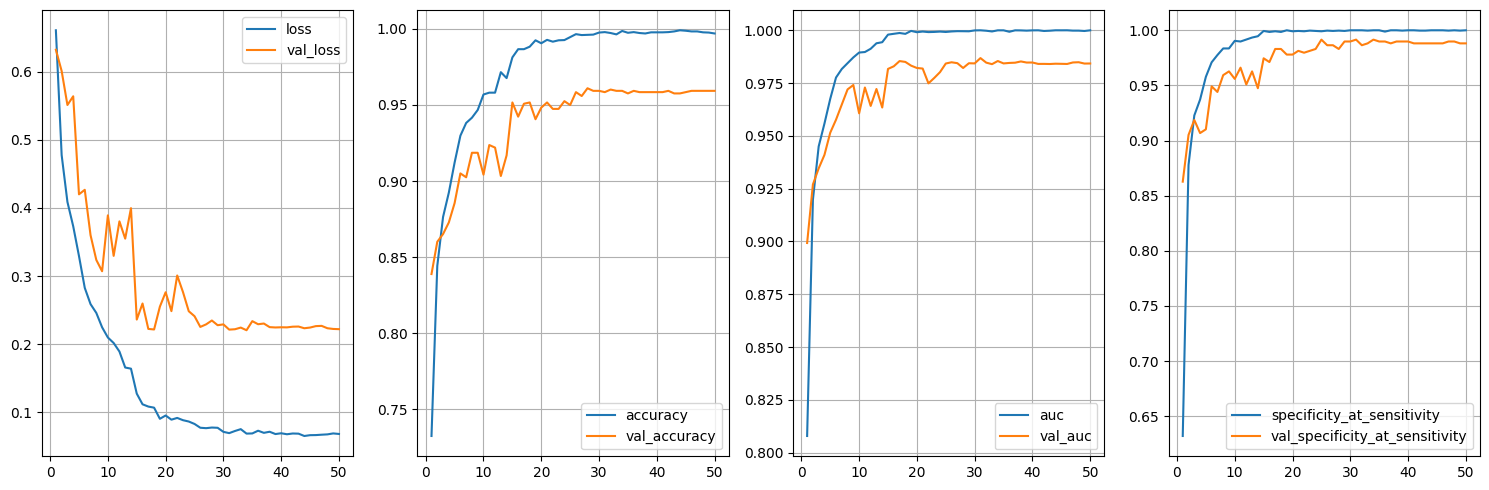

105/105 [==============================] - 23s 211ms/step - loss: 0.0681 - accuracy: 0.9970 - auc: 1.0000 - specificity_at_sensitivity: 1.0000 - val_loss: 0.2219 - val_accuracy: 0.9593 - val_auc: 0.9843 - val_specificity_at_sensitivity: 0.9881 - lr: 1.0000e-07


In [10]:
with tf.device('/GPU:0'):
    
    # Create and compile the CNN model
    cnn_model = create_cnn_model()
    
    # Checkpoint callbacks
    best_checkpoint_path = f"{MODEL}_nn{NEURONS}_lr{int(LEARN_RATE * 10000):04}_{ACTIVATION}_batch{BATCH_SIZE}_epoch{EPOCHS}_{VERSION}_best.keras"
    best_checkpoint_callback = ModelCheckpoint(filepath=best_checkpoint_path, save_best_only=True)

    final_checkpoint_path = f"{MODEL}_nn{NEURONS}_lr{int(LEARN_RATE * 10000):04}_{ACTIVATION}_batch{BATCH_SIZE}_epoch{EPOCHS}_{VERSION}_final.keras"
    final_checkpoint_callback = ModelCheckpoint(filepath=final_checkpoint_path)

    # Reducing learning rate
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, min_lr=1e-7)

    # Train the model
    history = cnn_model.fit(
        train_dataset,
        batch_size=BATCH_SIZE,    
        epochs=EPOCHS,
        verbose=1,
        validation_data=validation_dataset,    
        callbacks=[plot_learning(), best_checkpoint_callback, final_checkpoint_callback, reduce_lr_callback]
    )

In [11]:
#CNN_MODEL = load_model(best_checkpoint_path)
#CNN_MODEL.save_weights(f"{MODEL}_nn{NEURONS}_lr{int(LEARN_RATE * 10000):04}_{ACTIVATION}_batch{BATCH_SIZE}_epoch{EPOCHS}_kaggle_weights_{VERSION}.h5")